# Train Neural Network
## Parse and prepare the data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import joblib
import pandas as pd
import tensorflow as tf
import os
import fileinput
# import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Ftrl
from tensorflow.keras.layers import Dropout

import time

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run

TensorFlow version = 2.6.2



In [2]:
# SEED = 1337
# np.random.seed(SEED)
# tf.random.set_seed(SEED)

CLASSES = [];

# get all csv files and uses their names for the classes
for file in os.listdir("../data/10-05_shortsamples"):
    if file.endswith(".csv"):
        CLASSES.append(os.path.splitext(file)[0])
# sort the classes
CLASSES.sort()

print(CLASSES)

['box-own', 'laptop10-05', 'pc-combined', 'phone-own', 'printer-combined']


In [3]:
NUM_CLASSES = len(CLASSES) # get the number of classes

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_CLASSES = np.eye(NUM_CLASSES)

# the input and output tensor
inputs = []
outputs = []

# determines how many samples to use for each input
# SAMPLES_PER_CLASS = 30
SAMPLES_PER_CLASS = 10 # this amount of samples is used for the demo model (because otherwise classification takes 5 minutes = long)

# read each csv file and push an input and output
for class_index in range(NUM_CLASSES):
  objectClass = CLASSES[class_index]
  df = pd.read_csv("../data/10-05_shortsamples/" + objectClass + ".csv")
  # drop any unused parameters
  df = df.drop(columns=['time'])
  df = df.drop(columns=['Voltage'])
  df = df.drop(columns=['Factor'])
  columns = list(df)
  # get rid of empty value lines of csv which cause NaN inputs to TensorFlow
  df = df.dropna()
  df = df.reset_index(drop=True)

  # calculate the number of objectClass recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_CLASS)
  print(f"\u001b[32;4m{objectClass}\u001b[0m class will be output \u001b[32m{class_index}\u001b[0m of the classifier")
  print(f"{num_recordings} samples captured for training with inputs {list(df)} \n")
  
  #tensors
  output = ONE_HOT_ENCODED_CLASSES[class_index]
  # fill the input and output tensors
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_CLASS):
        # the index of the next sample to add
        index = i * SAMPLES_PER_CLASS + j
        tensor += [
            df['ApparentPower'][index],
            df['Current'][index],
            # df['Factor'][index],
            df['Power'][index],
            df['ReactivePower'][index],        
        ]
    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)

# Scale the columns of X to be between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler()
inputs_scaled = scaler.fit_transform(inputs)
joblib.dump(scaler, 'scaler.gz')

# print shape of an input
print(inputs[0].shape)
outputs = np.array(outputs) # convert the outputs to a numpy array
print(CLASSES)


box-own class will be output 0 of the classifier
7889 samples captured for training with inputs ['ApparentPower', 'Current', 'Power', 'ReactivePower'] 

laptop10-05 class will be output 1 of the classifier
7540 samples captured for training with inputs ['ApparentPower', 'Current', 'Power', 'ReactivePower'] 

pc-combined class will be output 2 of the classifier
51735 samples captured for training with inputs ['ApparentPower', 'Current', 'Power', 'ReactivePower'] 

phone-own class will be output 3 of the classifier
679 samples captured for training with inputs ['ApparentPower', 'Current', 'Power', 'ReactivePower'] 

printer-combined class will be output 4 of the classifier
29799 samples captured for training with inputs ['ApparentPower', 'Current', 'Power', 'ReactivePower'] 

(40,)
['box-own', 'laptop10-05', 'pc-combined', 'phone-own', 'printer-combined']


In [4]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs_scaled = inputs_scaled[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs_scaled, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")
print(inputs_test)
print(num_inputs)

Data set randomization and splitting complete.
[[0.06066536 0.06433722 0.02927928 ... 0.06550952 0.03111111 0.06741573]
 [0.02739726 0.03105935 0.01126126 ... 0.03135498 0.01111111 0.03370787]
 [0.02544031 0.02551303 0.00225225 ... 0.02575588 0.00222222 0.03370787]
 ...
 [0.02544031 0.02773156 0.01126126 ... 0.02799552 0.01111111 0.03146067]
 [0.41291585 0.39267887 0.40540541 ... 0.39193729 0.38888889 0.26067416]
 [0.2407045  0.24847476 0.21846847 ... 0.24636058 0.21777778 0.16629213]]
97642


# Build & Train the Model

Build and train a TensorFlow model using the high-level Keras API.

In [5]:
# https://www.kaggle.com/getting-started/174307
from sklearn.metrics import accuracy_score

# callback to only print metrics every X epochs
class Callback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X = X_val
        self.y = y_val.argmax(axis=1)
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch == 0:
            return
        if epoch%10==0: #Hier aanpassan na hoeveel epochs je wilt zien
            pred = (model.predict(self.X))
            print('epoch: ',epoch, ' | loss: ', str(logs['loss']), '| val_loss: ', str(logs['val_loss']), '| accuracy: ', accuracy_score(self.y,pred.argmax(axis=1)))

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10) # early stopping -> will sotp training if no improvement for 10 epochs
# build the model and train it
model = tf.keras.Sequential()
# model.add(Dropout(0.5))
model.add(tf.keras.layers.Dense(100, activation='relu')) # relu is used for performance (50
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(200, activation='relu')) #30
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(100, activation='relu')) #20
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')) # softmax is used, because we only expect one class to occur per input
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

history = model.fit(inputs_train, outputs_train, epochs=150, batch_size=16, validation_data=(inputs_validate, outputs_validate), callbacks=[Callback(inputs_validate, outputs_validate)], verbose=0)
model.summary() #500 32

2023-05-15 13:06:25.991208: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-15 13:06:25.991226: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 9712c8604b07
2023-05-15 13:06:25.991231: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 9712c8604b07
2023-05-15 13:06:25.991272: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.105.17
2023-05-15 13:06:25.991283: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.105.17
2023-05-15 13:06:25.991286: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.105.17
2023-05-15 13:06:25.991717: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU in

epoch:  10  | loss:  0.00804155319929123 | val_loss:  0.0069763208739459515 | accuracy:  0.9789543755440627
epoch:  20  | loss:  0.006607711780816317 | val_loss:  0.004703879822045565 | accuracy:  0.9860207895949613
epoch:  30  | loss:  0.005331316497176886 | val_loss:  0.004222037736326456 | accuracy:  0.9876081724614676
epoch:  40  | loss:  0.005082754418253899 | val_loss:  0.003965077456086874 | accuracy:  0.9884786727431
epoch:  50  | loss:  0.004973090253770351 | val_loss:  0.0034756488166749477 | accuracy:  0.990322085104204
epoch:  60  | loss:  0.00445502158254385 | val_loss:  0.0033000533003360033 | accuracy:  0.9909365558912386
epoch:  70  | loss:  0.004235248547047377 | val_loss:  0.00778419291600585 | accuracy:  0.9762404629013263
epoch:  80  | loss:  0.004136102739721537 | val_loss:  0.0039435881190001965 | accuracy:  0.9897588202160889
epoch:  90  | loss:  0.004248088225722313 | val_loss:  0.003997774329036474 | accuracy:  0.9886322904398587
epoch:  100  | loss:  0.0041630

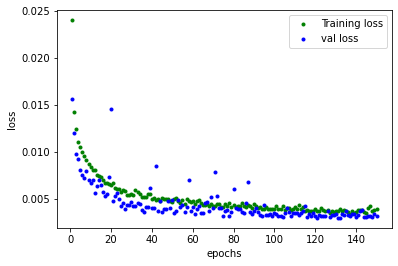

In [6]:
# get the training loss and validation loss history values
loss = history.history['loss']
val_loss = history.history['val_loss']

# the number of epochs
epochs = range(1, len(loss)+1)

# plot the training and validation loss
plt.plot(epochs, loss, 'g.', label="Training loss")
plt.plot(epochs, val_loss, 'b.', label="val loss")

plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

# Run with Test Data

(19528, 40)
predictions =
 [[0.    0.    1.    0.    0.   ]
 [0.994 0.    0.    0.    0.006]
 [0.    0.    1.    0.    0.   ]
 ...
 [0.    0.    0.    0.    1.   ]
 [0.    0.    1.    0.    0.   ]
 [0.    0.    1.    0.    0.   ]]
actual =
 [[0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]
[[9.85218509e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 9.67092008e-01 4.58584122e-03 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 3.29079919e-02 9.94936467e-01 7.63358779e-03
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.82153435e-04 9.92366412e-01
  0.00000000e+00]
 [1.47814910e-02 0.00000000e+00 9.55383587e-05 0.00000000e+00
  1.00000000e+00]]


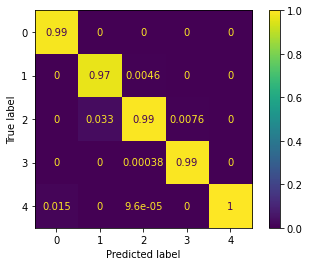

In [7]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)
print(inputs_test.shape)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

y_prediction = np.argmax(predictions, axis = 1)
y_test=np.argmax(outputs_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
disp =  ConfusionMatrixDisplay(confusion_matrix=result)
print(result)
disp.plot()

In [8]:
# save the model
model.save('classification_15-05_simple/')

2023-05-15 13:10:54.672134: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: classification_15-05_simple/assets


In [9]:
# save the notebook
!tar chvfz notebook.tar.gz *

classification_15-05_simple/
classification_15-05_simple/keras_metadata.pb
classification_15-05_simple/saved_model.pb
classification_15-05_simple/assets/
classification_15-05_simple/variables/
classification_15-05_simple/variables/variables.index
classification_15-05_simple/variables/variables.data-00000-of-00001
classification_17-04_shortsamples/
classification_17-04_shortsamples/keras_metadata.pb
classification_17-04_shortsamples/saved_model.pb
classification_17-04_shortsamples/assets/
classification_17-04_shortsamples/variables/
classification_17-04_shortsamples/variables/variables.index
classification_17-04_shortsamples/variables/variables.data-00000-of-00001
classification_17-04V2/
classification_17-04V2/keras_metadata.pb
classification_17-04V2/saved_model.pb
classification_17-04V2/assets/
classification_17-04V2/variables/
classification_17-04V2/variables/variables.index
classification_17-04V2/variables/variables.data-00000-of-00001
classification_17-04V3/
classification_17-04V3/k